In [21]:
# import things
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify
import tensorflow.keras.backend as K

In [22]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
# Load the model you trained in task5_training.ipynb
patch_size = 256
example_file_name = f'artjom_234535_unet_model_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [24]:
# Define any functions you need to process the mask e.g. Task 2
def detect_and_crop_petri_dish(image_path):
    image = cv2.imread(image_path, 0)  # Load grayscale image
    original_image = cv2.imread(image_path)  # Load original image

    blurred = cv2.medianBlur(image, 5)  # Reduce noise
    _, binary_image = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)

    kernel = np.ones((9, 9), np.uint8)
    dilated = cv2.dilate(binary_image, kernel, iterations=3)
    closed = cv2.erode(dilated, kernel, iterations=4)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    size = max(w, h)
    x_center, y_center = x + w // 2, y + h // 2
    x_start, y_start = x_center - size // 2, y_center - size // 2
    x_end, y_end = x_start + size, y_start + size

    cropped_image = original_image[max(0, y_start):min(image.shape[0], y_end),
                                   max(0, x_start):min(image.shape[1], x_end)]

    return cropped_image, (max(0, x_start), max(0, y_start), min(image.shape[1], x_end), min(image.shape[0], y_end))

In [25]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)  # Grayscale image
original_image = cv2.imread(task5_test_image_path)  # Load the original image
h, w = image.shape
h, w

(3006, 4112)

In [26]:
# Find the petri dish
cropped_image, crop_coordinates = detect_and_crop_petri_dish(task5_test_image_path)
cropped_image.shape

(2721, 2721, 3)

In [27]:
# Pad the petri dish
height, width = cropped_image.shape[:2]
pad_h = (patch_size - height % patch_size) % patch_size
pad_w = (patch_size - width % patch_size) % patch_size
petri_dish_padded = np.pad(cropped_image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
petri_dish_padded.shape

(2816, 2816, 3)

In [28]:
# PATCH
# Split the Petri dish into patches
dish_patches = patchify(petri_dish_padded, (patch_size, patch_size, 3), step=patch_size)

In [29]:
# PREDICT
# Predict each patch
predicted_patches = []
for i in range(dish_patches.shape[0]):
    for j in range(dish_patches.shape[1]):
        patch = dish_patches[i, j, 0]
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)  # Convert RGB to grayscale
        patch = patch / 255.0  # Normalize the patch
        patch = np.expand_dims(patch, axis=(0, -1))  # Match model input shape
        prediction = model.predict(patch)
        predicted_patches.append(prediction[0, :, :, 0])

predicted_patches = np.array(predicted_patches)
predicted_patches = predicted_patches.reshape(dish_patches.shape[0], dish_patches.shape[1], patch_size, patch_size)

1/1 [==============================] - 0s 87ms/step


Text(0.5, 1.0, 'Prediction')

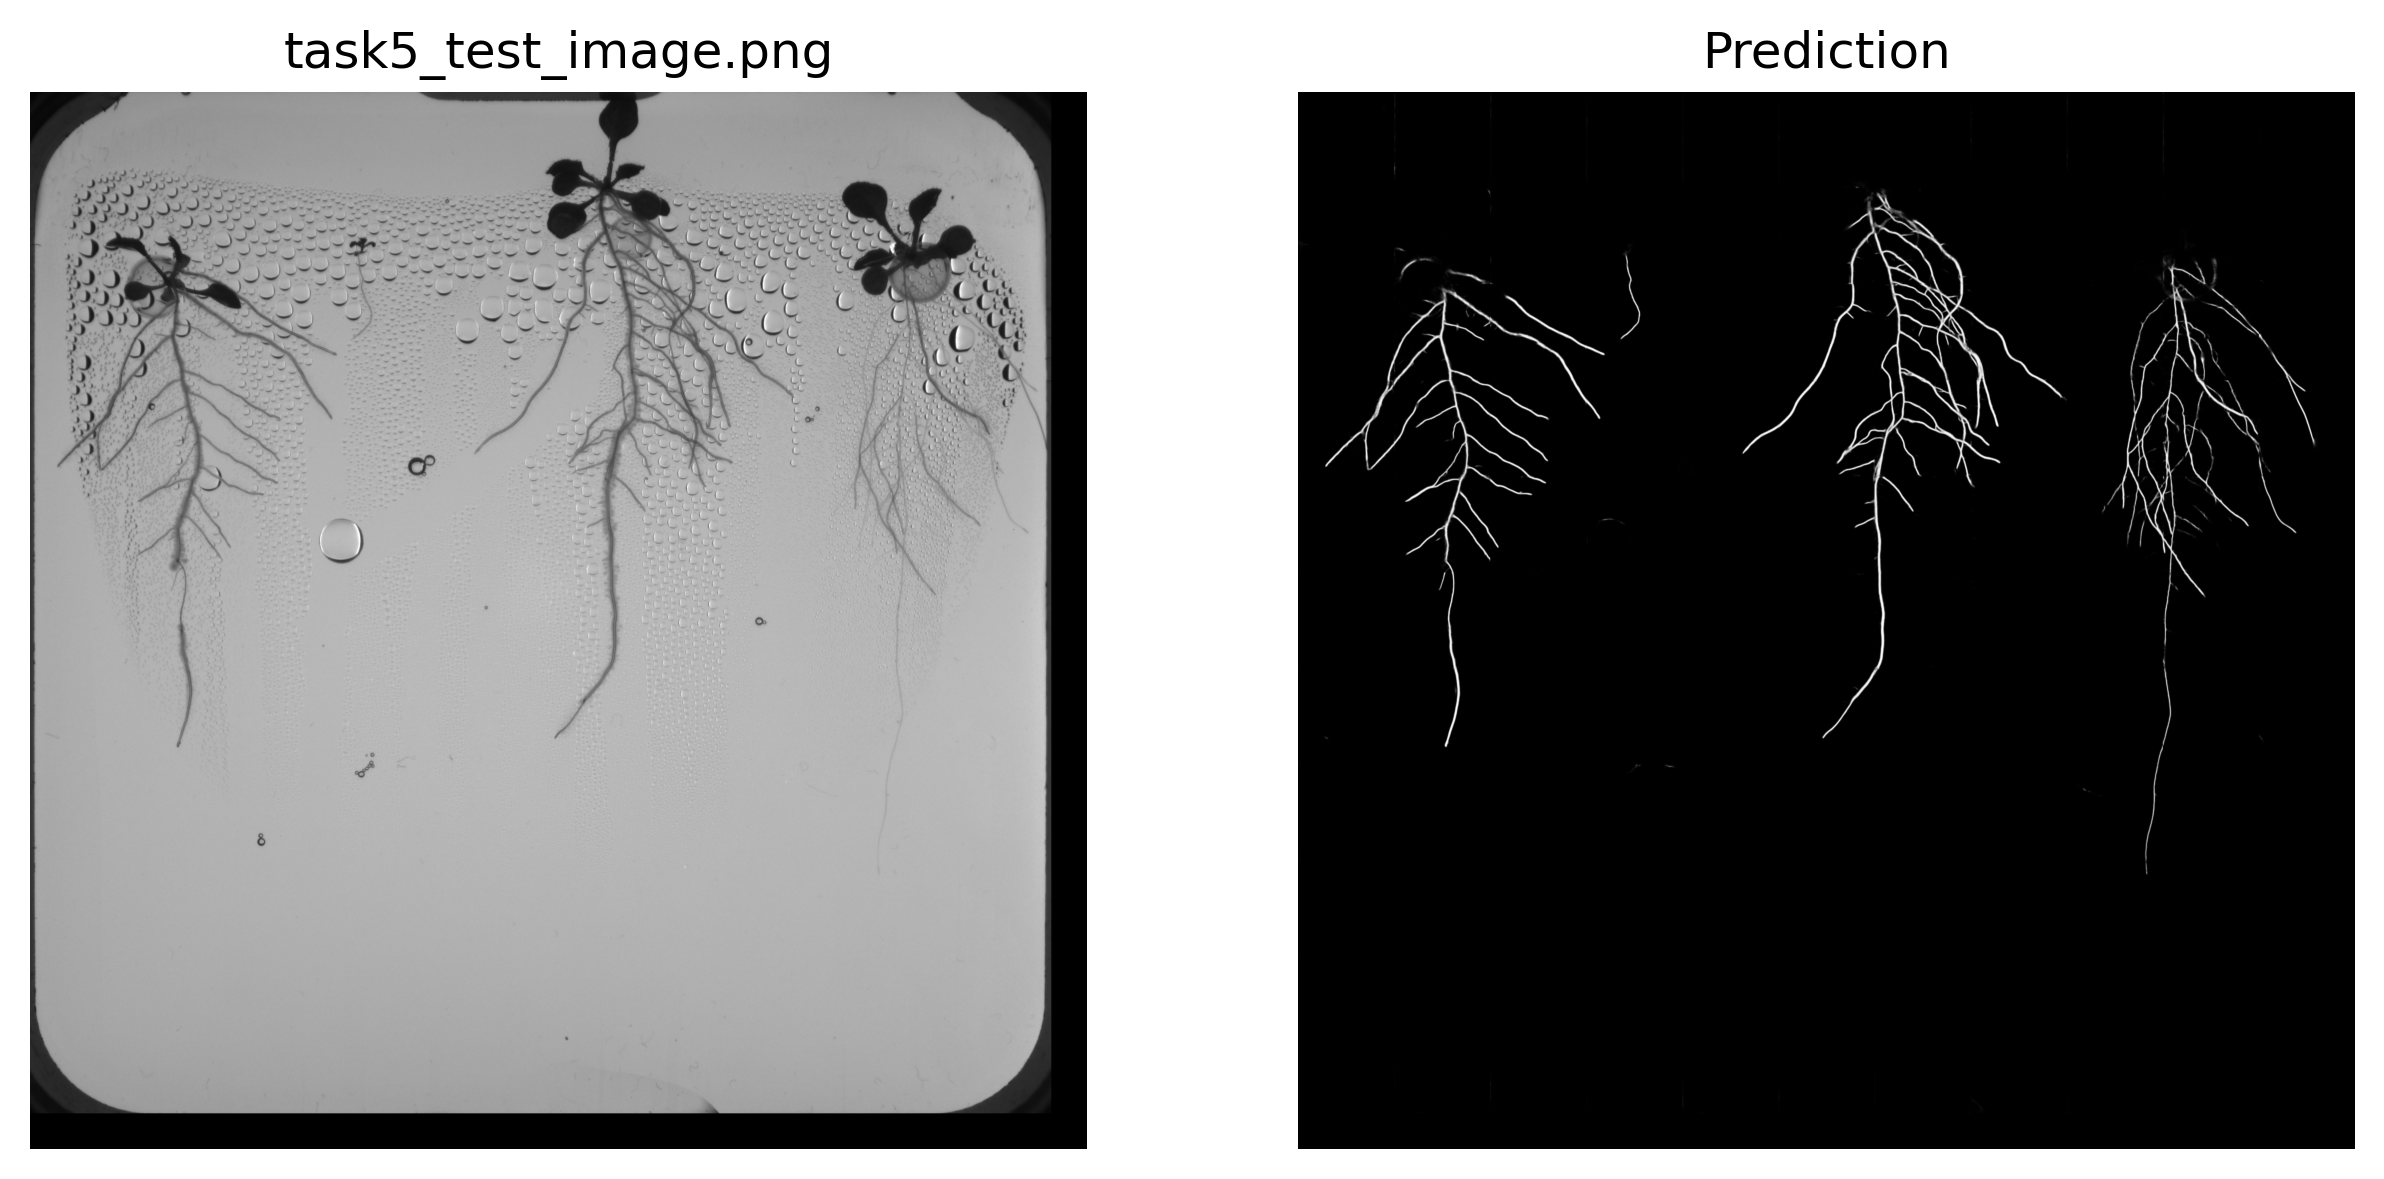

In [30]:
# UNPATCH
# Reconstruct the full mask from patches
predicted_mask = unpatchify(predicted_patches, petri_dish_padded.shape[:2])

# Display results
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [31]:
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [32]:
# Apply the corrections
# Align the predicted mask with the original image
def align_mask_to_original(predicted_mask, original_image, crop_coordinates):
    h, w = original_image.shape[:2]
    aligned_mask = np.zeros((h, w), dtype=np.float32)
    x_start, y_start, x_end, y_end = crop_coordinates

    adjustment = 100
    x_end += adjustment
    y_end += adjustment

    cropped_h, cropped_w = y_end - y_start, x_end - x_start
    resized_mask = cv2.resize(predicted_mask, (cropped_w, cropped_h), interpolation=cv2.INTER_LINEAR)

    aligned_mask[y_start:y_end, x_start:x_end] = resized_mask
    return aligned_mask

# Correct and align the predicted mask
predicted_mask_corrected = align_mask_to_original(predicted_mask, original_image, crop_coordinates)
predicted_mask_corrected.shape

(3006, 4112)

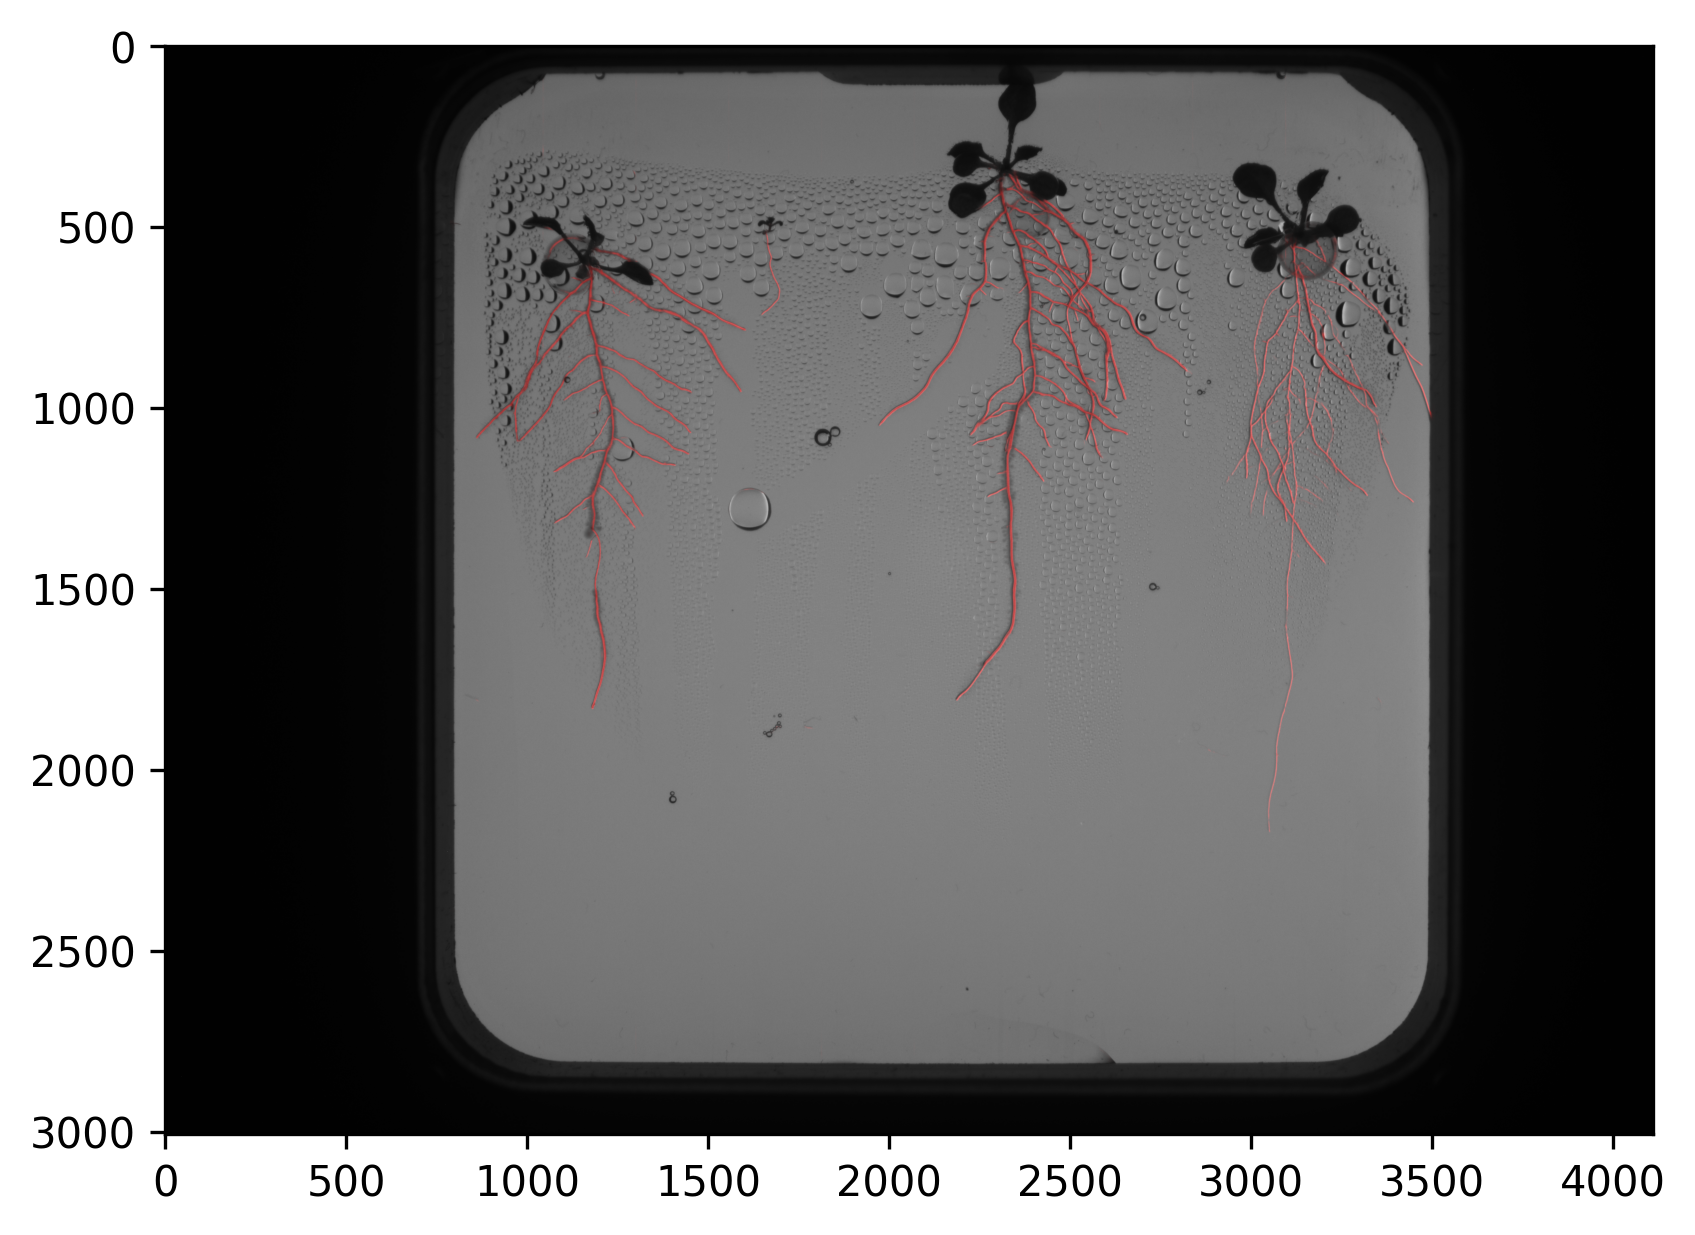

In [33]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.

# Overlay prediction on original image
predicted_mask_colored = np.zeros_like(original_image, dtype=np.uint8)
predicted_mask_colored[:, :, 2] = (predicted_mask_corrected * 255).astype(np.uint8)  # Red channel
overlay_image = cv2.addWeighted(original_image, 0.7, predicted_mask_colored, 0.5, 0)

# Display overlay image
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

In [34]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected * 255).astype(np.uint8)
assert predicted_mask_corrected.shape == image.shape
prediction_file_name = 'task5_test_image_prediction_artjom_234535.png'
cv2.imwrite(prediction_file_name, mask_image)

True

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.